<a href="https://colab.research.google.com/github/adin786/ad-titanic/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic survivor prediction
Based on Kaggle titanic dataset and competition:
https://www.kaggle.com/c/titanic

The objective is to load, clean, explore the titanic passenger data and build a classification model to predict whether an individual was likely to survive or not.

I followed along with and took inspiration from [this notebook](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#2.-Feature-Engineering)

In [1]:
# Initialise things in Kaggle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import time
 
path = os.path.join('drive','MyDrive','Data','titanic')
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/Data/titanic/gender_submission.csv
drive/MyDrive/Data/titanic/test.csv
drive/MyDrive/Data/titanic/train.csv


# Load data

In [2]:
# Load the training and testing data
df_train = pd.read_csv(os.path.join(path,'train.csv'))
df_test = pd.read_csv(os.path.join(path,'test.csv'))
print(f'Training set shape: {df_train.shape}')
print(f'Testing  set shape: {df_test.shape}')

Training set shape: (891, 12)
Testing  set shape: (418, 11)


In [3]:
for col in df_train.columns:
  if col in df_test.columns:
    print(f'{col:<15} in both')
  else:
    print(f'{col:<15} in training set but not in test set')

PassengerId     in both
Survived        in training set but not in test set
Pclass          in both
Name            in both
Sex             in both
Age             in both
SibSp           in both
Parch           in both
Ticket          in both
Fare            in both
Cabin           in both
Embarked        in both


Testing data is the data my model is to be evaluated over and submitted to Kaggle.

It needs to be prepared in an identical way to the training data.  While I am messing around and building features etc, it is a good idea to append the datasets. When it comes to model training I will then split them back out into separate dataframes so I only train on the 

**Note:** Only difference is one less column in the test set. There are no "Survived" values, so this will introduce 418 NaNs to that column.  

In [4]:
# Save a number of rows to split by later, this just lets us do same preprocessing on both together
rows_to_split = len(df_train)
df = df_train.append(df_test, ignore_index=True)
print(f'Full dataframe for processing: {df.shape}')

Full dataframe for processing: (1309, 12)


## Data summary

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
# Describe for string/categorical features
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
# Num unique values in each column
df.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

# Exploration

## Correlations

In [10]:
# Print the "pearson" correlation values for each column vs "Survived"
corr_mat = df.corr()
corr_mat['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

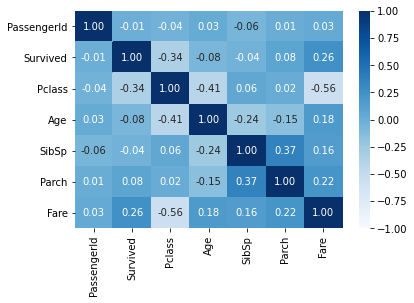

In [11]:
# Visualise the correlation values - Light and dark colours are most correlated
corr_mat = df.corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_mat,vmax=1,vmin=-1,annot=True, fmt=".2f",cmap='Blues');

Correlation with target variable:
- Pclass has a strong -ve correlation with Survived (lower class number means better chance of survival)
- Fare has a strong +ve correlation with Survived (more expensive tickets increased the survival probability)
- Age is slightly -ve correlated (younger people more likely to survive

Colinearity of other features:
- Pclass and Fare are highly correlated, makes sense for ticket class to relate to price
- SibSp and Parch are highly correlated also, again makes sense for people with big families onboard to have high parent/child numbers and also high numbers of siblings/spouses. 

## Distributions

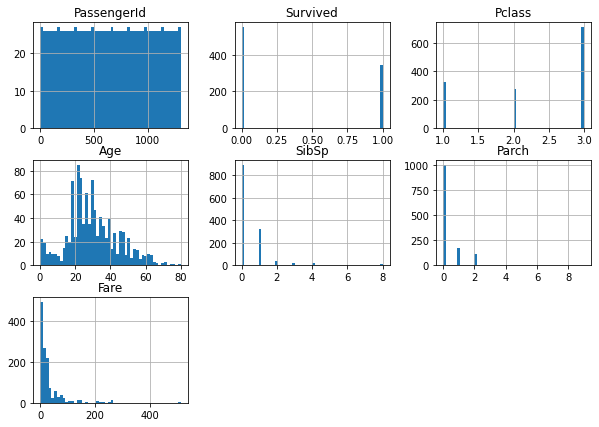

In [12]:
# Check dirstributions of each feature
df.hist(bins=50, figsize=(10,7));

- PassengerId is uniform (makes sense if everyone has unique ID)
- Survived is binary (this is the target variable)
- Pclass is fairly random, can be made categorical
- Age is normally distributed
- SibSp is exponential, can be made categorical
- Parch is exponential, can be made categorical
- Fare is exponential

## Data types

In [13]:
# Set the data types for each feature
# df.Pclass = df.Pclass.astype('category')

## Missing data

In [14]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print(f'{col:<15} column missing values: {df[col].isnull().sum()}')
    print('\n')
    
display_missing(df)

PassengerId     column missing values: 0
Survived        column missing values: 418
Pclass          column missing values: 0
Name            column missing values: 0
Sex             column missing values: 0
Age             column missing values: 263
SibSp           column missing values: 0
Parch           column missing values: 0
Ticket          column missing values: 0
Fare            column missing values: 1
Cabin           column missing values: 1014
Embarked        column missing values: 2




- Survived has 418 missing, but these are all from the testing (submission) dataset which was appended to the training data.
- Age has 263 missing, that's a lot.  Dataset is small, so can't just drop these, will need to impute.
- Fare has one missing value.
- Cabin has 1014 missing values.  That's massive
- Embarked has 2 columns missing.  Will try to impute, if not then drop

# Cleaning and feature engineering

## Add name title

In [15]:
# Define a function to do string compare
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        #print(substring, big_string)
        if big_string is np.nan:
            return np.nan
        if substring in big_string:
            return substring
    print(big_string)
    return np.nan

In [16]:
# Use this block of code to iterate through the whole Name column,  printing any 
# names it couldn't match. Check the unmatched names and manually add a title to 
# the titles list.  Should output nothing if all names matched.
titles = ['Mr.','Mrs.','Miss.','Master','Don.','Dona.',
          'Rev.','Dr.','Mme.','Ms.','Major.',
          'Lady.','Sir.','Mlle.','Col','Capt.',
          'Countess.','Jonkheer.']

for thisName in df['Name']:
  substrings_in_string(thisName,titles)

In [17]:
def add_titles(df):
  df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, titles))
  df.Title = df.Title.astype('category')
  return df

df = add_titles(df)

#Check first 10 names converted OK
for i in range(1,10):
  name = df.Name.iloc[i]
  print(f'{name:<55}...extracted: {df.Title.iloc[i]}')

Cumings, Mrs. John Bradley (Florence Briggs Thayer)    ...extracted: Mrs.
Heikkinen, Miss. Laina                                 ...extracted: Miss.
Futrelle, Mrs. Jacques Heath (Lily May Peel)           ...extracted: Mrs.
Allen, Mr. William Henry                               ...extracted: Mr.
Moran, Mr. James                                       ...extracted: Mr.
McCarthy, Mr. Timothy J                                ...extracted: Mr.
Palsson, Master. Gosta Leonard                         ...extracted: Master
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)      ...extracted: Mrs.
Nasser, Mrs. Nicholas (Adele Achem)                    ...extracted: Mrs.


Looks successful, created this as an add_titles() function

### For interest

In [18]:
# How many in each title category
df.groupby(['Title'])['Survived'].mean().sort_values(ascending=False)

Title
Sir.         1.000000
Lady.        1.000000
Ms.          1.000000
Countess.    1.000000
Mme.         1.000000
Mlle.        1.000000
Mrs.         0.792000
Miss.        0.697802
Master       0.575000
Major.       0.500000
Col          0.500000
Dr.          0.428571
Mr.          0.156673
Rev.         0.000000
Jonkheer.    0.000000
Don.         0.000000
Capt.        0.000000
Dona.             NaN
Name: Survived, dtype: float64

## Fix missing Age
This will be tricky to impute nicely. Could simply impute with a mean/median for every missing value, but median age could be strongly connected to categories like Sex, SibSp, etc

I think it will be more successful if we group the dataset up and insert median of each category.

In [19]:
# Printing the correlation values against Age.
df.corr()['Age'].abs().sort_values(ascending=False)

Age            1.000000
Pclass         0.408106
SibSp          0.243699
Fare           0.178740
Parch          0.150917
Survived       0.077221
PassengerId    0.028814
Name: Age, dtype: float64

Age is strongly correllated with numerical features like Pclass, SibSp

In [20]:
# Median age for each num of siblings / spouses, alongside count
piv = pd.pivot_table(data=df, index='SibSp', aggfunc={'Age':[('median',np.median),('count',len)]})
piv.reindex([('Age', 'median'),('Age',  'count')], axis=1)

Age       
      median  count
SibSp              
0       28.0  891.0
1       30.0  319.0
2       21.5   42.0
3       14.5   20.0
4        7.0   22.0
5       10.5    6.0
8       14.5    9.0

So people with fewer siblings onboard tended to be older, seems intuitive.  But there are very few people in the high Sibsp categories.  So this will not give a lot of statistical significance to those median values.

Instead let's try the same with Pclass (which was strongly correlated with Age)


In [21]:
# Median age for each ticket class, alongside count
piv = pd.pivot_table(data=df, index='Pclass', aggfunc={'Age':[('median',np.median),('count',len)]})
piv.reindex([('Age', 'median'),('Age',  'count')], axis=1)

Age       
       median  count
Pclass              
1        39.0  323.0
2        29.0  277.0
3        24.0  709.0

There is data about Sex, let's try looking at whether Sex is linked to age distributions

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,388.0,28.687088,14.576962,0.17,19.0,27.0,38.0,76.0
male,658.0,30.585228,14.280581,0.33,21.0,28.0,39.0,80.0


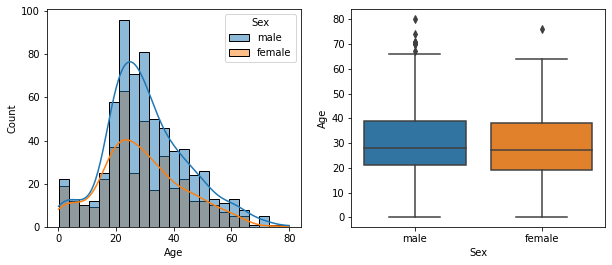

In [22]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10,18)
sns.histplot(ax=axs[0],data=df, x='Age', hue='Sex', kde=True);
sns.boxplot(ax=axs[1],data=df, y='Age', x='Sex');

df.groupby(['Sex']).describe()['Age']

Sex category doesn't realy correlate with Age very strongly on it's own, but:
- Females are generally younger in this dataset, though median/50% quartile is only 1 year less.
- All quartiles are lower in age, median is lower too.

---

So let's pick both categories and group the dataset by these together, Sex and ticket class.

In [23]:
pd.pivot_table(data=df, index=['Sex','Pclass'], aggfunc={'Age':[('median',np.median),('count',len)]})

Age       
               count median
Sex    Pclass              
female 1       144.0   36.0
       2       106.0   28.0
       3       216.0   22.0
male   1       179.0   42.0
       2       171.0   29.5
       3       493.0   25.0

That looks promising, so there's a bit more distinction between ticket groups of

Also, each of these groups has over 100 instances, so statistical significance is decent.  Let's write a function to impute on this basis.

In [24]:
def fill_ages(df):
  # Apply a lambda function to fill the nans of each group.
  df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
  return df

df = fill_ages(df)

# As a check, reprint the median of each group in the modified df, it shouldn't have changed.
pd.pivot_table(data=df, index=['Sex','Pclass'], aggfunc={'Age':[('median',np.median),('count',len)]})

Age       
               count median
Sex    Pclass              
female 1       144.0   36.0
       2       106.0   28.0
       3       216.0   22.0
male   1       179.0   42.0
       2       171.0   29.5
       3       493.0   25.0

Check status of missing values now

In [25]:
display_missing(df)

PassengerId     column missing values: 0
Survived        column missing values: 418
Pclass          column missing values: 0
Name            column missing values: 0
Sex             column missing values: 0
Age             column missing values: 0
SibSp           column missing values: 0
Parch           column missing values: 0
Ticket          column missing values: 0
Fare            column missing values: 1
Cabin           column missing values: 1014
Embarked        column missing values: 2
Title           column missing values: 0




So Cabin still has loads of missing data, let's look at that next

## Add Deck category from Cabin
Extract the deck number feature from the Cabin name and use it to bin up the Cabins into Deck categories, which will be easy to train a model with.

Maybe people certain decks were more likely to get into a lifeboat.

With so many missing records of "Cabin", I will just assign them a "missing" category when I bin them into Deck categories.

In [26]:
# Use this block of code to iterate through the whole Cabin column, printing any 
# cabin numbers it couldn't match. Check the unmatched cabins and manually add a 
# Deck category to the decks list. Should output nothing if all cabins matched.
decks = ['A','B','C','D','E','F','G','T']
for thisCabin in df['Cabin']:
    substrings_in_string(thisCabin,decks)

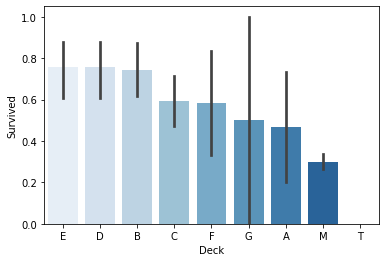

In [27]:
def add_decks(df):
  # Group by Deck, print probability of survival for each
  df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, decks))
  # Insert 'M' for nan values
  df['Deck'] = df['Deck'].fillna('M')
  return df

df = add_decks(df)

# Plot the probability of survival based on deck
order_list = df.groupby(['Deck']).mean()['Survived'].sort_values(ascending=False).index
sns.barplot(data=df,x='Deck',y='Survived',estimator=np.mean,palette='Blues',order=order_list);

- Deck D, E, B all have close to 75% survival rates.
- A lot of veriability in survival on deck G.
- Nobody on deck T survived.

### For interest
Break this down by sex also.  So Sex is a great predictor of survival, especially coupled with Deck.

In [28]:
df.groupby(['Sex','Deck']).mean()['Survived'].sort_values(ascending=False)

Sex     Deck
female  F       1.000000
        D       1.000000
        B       1.000000
        A       1.000000
        E       0.937500
        C       0.888889
        M       0.654378
male    E       0.588235
female  G       0.500000
male    D       0.466667
        A       0.428571
        B       0.400000
        F       0.375000
        C       0.343750
        M       0.136170
        T       0.000000
Name: Survived, dtype: float64

Now looking at how survival chance rises with ticket class.  1st Class has much higher chance of survival

In [29]:
df.groupby(['Pclass'],dropna=False).mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Again Sex and Pclass here are great predictors, strong relationships are apparent in predicting survival rate.

In [30]:
df.groupby(['Sex','Pclass'],dropna=False).mean()['Survived']

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

For info. Only one guy was in deck T, didn't survive

In [31]:
df[df['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr.,T


## Fix missing Embarked values

In [32]:
df[df['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.,B
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.,B


In [33]:
# Guide I'm following googled the names and worked out they embarked from Southampton 'S'!
# Fillna using this info
df['Embarked'] = df['Embarked'].fillna('S')
 
# Check nans left in dataset
display_missing(df)

PassengerId     column missing values: 0
Survived        column missing values: 418
Pclass          column missing values: 0
Name            column missing values: 0
Sex             column missing values: 0
Age             column missing values: 0
SibSp           column missing values: 0
Parch           column missing values: 0
Ticket          column missing values: 0
Fare            column missing values: 1
Cabin           column missing values: 1014
Embarked        column missing values: 0
Title           column missing values: 0
Deck            column missing values: 0




Missing values remain in Fare.  Don't think these are worth worrying about.  Will drop these 2 rows.

## Fix nan values in Embarked column

In [34]:
df[df['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck


In [35]:
# Guide I'm following googled the names and worked out they embarked from Southampton 'S'
# Fillna using this info
df['Embarked'] = df['Embarked'].fillna('S')

In [36]:
display_missing(df)

PassengerId     column missing values: 0
Survived        column missing values: 418
Pclass          column missing values: 0
Name            column missing values: 0
Sex             column missing values: 0
Age             column missing values: 0
SibSp           column missing values: 0
Parch           column missing values: 0
Ticket          column missing values: 0
Fare            column missing values: 1
Cabin           column missing values: 1014
Embarked        column missing values: 0
Title           column missing values: 0
Deck            column missing values: 0




## Add family size
Add family size column

In [37]:
df['familysize'] = df['Parch'] + df['SibSp'] + 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,familysize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,M,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,M,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,M,1


## Bin Ticket frequency features

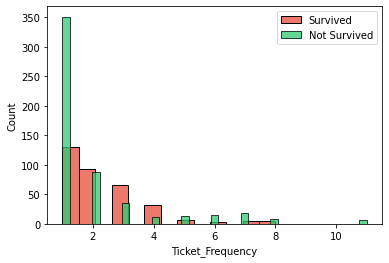

In [38]:
# Add Ticket frequency feature as there's otherwise too many unique values in the 
# Ticket column.  Frequency should tell if more than one person travelled on the same
# ticket number, indicating they were in a group.  Similar to familysize feature we added
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
df.head()

# Plot hist
ax1 = plt.axes()
sns.histplot(df[df['Survived']==1]['Ticket_Frequency'], label='Survived', color='#e74c3c', ax=ax1)
sns.histplot(df[df['Survived']==0]['Ticket_Frequency'], label='Not Survived', color='#2ecc71', ax=ax1)
ax1.legend(loc='upper right', prop={'size': 10})
plt.show()

# Model building

In [72]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [40]:
# Select the Features to model and 
X_all = df[['Title','Deck','Fare','Sex']]
y_all = df['Survived']
 
y = y_all[:rows_to_split]
X = X_all[:rows_to_split]
y_subm = y_all[rows_to_split:]
X_subm = X_all[rows_to_split:]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Train a dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
 
dummy_score = accuracy_score(y_train,dummy_clf.predict(X_train[['Fare','Title','Sex','Deck']]))
print(f'Dummy/null accuracy: {dummy_score:.3f}')

Dummy/null accuracy: 0.624


## Basic Logistic Regression

In [42]:
# Define a model pipeline
num_features = ['Fare']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
logreg_clf = Pipeline([('preprocessor', preprocessor),
                       ('model', LogisticRegression(max_iter=1000))])

In [43]:
# Train the model
tic = time.perf_counter()
logreg_clf.fit(X_train,y_train);
print(f'time to fit model: {time.perf_counter()-tic:.3f} sec')

time to fit model: 0.045 sec


### Accuracy

In [44]:
# Accuracy on train and test datasets
y_train_pred = logreg_clf.predict(X_train)
y_test_pred = logreg_clf.predict(X_test)
 
acc_train = accuracy_score(y_train,y_train_pred)
acc_test = accuracy_score(y_test,y_test_pred)
print(f'Accuracy on train set: {acc_train:.3f}')
print(f'Accuracy on test set:  {acc_test:.3f}')

Accuracy on train set: 0.796
Accuracy on test set:  0.788


### Cross validate
Get an indication of if model is overfitting or not.

In [45]:
# Cross validate over full labelled training data
cv_scores = cross_val_score(logreg_clf,X,y)
print(f'CV scores: {cv_scores}')
print(f'mean:  {cv_scores.mean():.3f}')
print(f'stdev: {cv_scores.std():.3f}')

CV scores: [0.77094972 0.78651685 0.76966292 0.75842697 0.79775281]
mean:  0.777
stdev: 0.014


### Confusion matrix

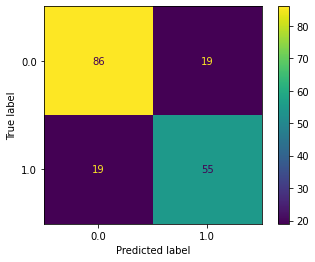

In [46]:
# Confusion matrix
plot_confusion_matrix(logreg_clf, X_test, y_test, values_format='d');

### Precision, Recall, F1, ROC-AUC
Precision = true_pos / (true_pos + false_pos)

Recall = true_pos / (true_pos + false_neg)

Precision score: 0.743
Recall score:    0.743


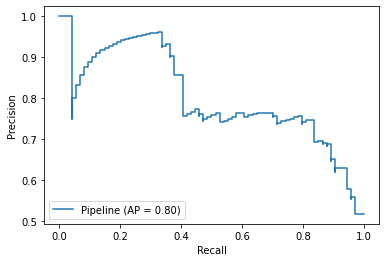

In [47]:
# Precision Recall curve
plot_precision_recall_curve(logreg_clf, X_test, y_test);
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f'Precision score: {precision:.3f}')
print(f'Recall score:    {recall:.3f}')

In [48]:
f1 = f1_score(y_test, y_test_pred)
print(f'F1 score: {f1:.3f}')

F1 score: 0.743


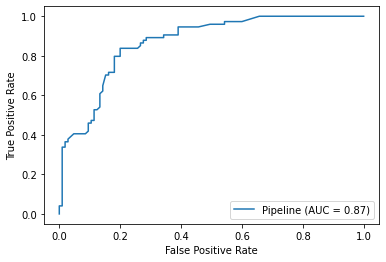

In [49]:
# ROC curve
plot_roc_curve(logreg_clf, X_test, y_test);

In [50]:
auc = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC score: {auc:.3f}')

ROC AUC score: 0.781


In [51]:
# Generate a little report
print(f'Accuracy on test set:  {acc_test:.3f}')
 
print(f'Precision score:       {precision:.3f}')
print(f'Recall score:          {recall:.3f}')
print(f'F1 score:              {f1:.3f}')
print(f'ROC AUC score:         {auc:.3f}\n')
 
print(f'CV scores: {cv_scores}')
print(f'mean:  {cv_scores.mean():.3f}')
print(f'stdev: {cv_scores.std():.3f}')

Accuracy on test set:  0.788
Precision score:       0.743
Recall score:          0.743
F1 score:              0.743
ROC AUC score:         0.781

CV scores: [0.77094972 0.78651685 0.76966292 0.75842697 0.79775281]
mean:  0.777
stdev: 0.014


## Grid Search

In [52]:
param_grid = {'model__C':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30]}
grid = GridSearchCV(logreg_clf, param_grid, verbose=1)

In [53]:
grid.fit(X_train,y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s finished


In [54]:
print(f'Best model params: {grid.best_params_}')
print(f'Best model score: {grid.best_score_:.3f}')

Best model params: {'model__C': 0.3}
Best model score: 0.792


## Decision tree

In [55]:
# Define a model pipeline
num_features = ['Fare']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
tree = Pipeline([('preprocessor', preprocessor),
                       ('tree', DecisionTreeClassifier())])

Accuracy on test set:  0.777
Precision score:       0.750
Recall score:          0.689
F1 score:              0.718
ROC AUC score:         0.764

CV scores: [0.77094972 0.76404494 0.84269663 0.76404494 0.80337079]
mean:      0.789
stdev:.    0.031


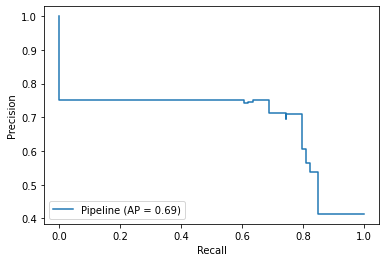

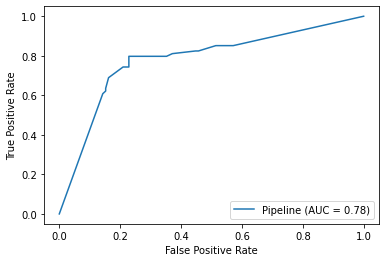

In [56]:
# make a function to speed up model evaluation
def evaluate_clf(clf):
   clf.fit(X_train,y_train);
   y_train_pred = clf.predict(X_train)
   y_test_pred = clf.predict(X_test)
   cv_scores = cross_val_score(clf,X,y)
 
   plot_precision_recall_curve(clf, X_test, y_test);
   plot_roc_curve(clf, X_test, y_test);
 
   acc_train = accuracy_score(y_train,y_train_pred)
   acc_test = accuracy_score(y_test,y_test_pred)
 
   precision = precision_score(y_test, y_test_pred)
   recall = recall_score(y_test, y_test_pred)
   f1 = f1_score(y_test, y_test_pred)
   auc = roc_auc_score(y_test, y_test_pred)
 
   # Generate a little report
   print(f'Accuracy on test set:  {acc_test:.3f}')
   print(f'Precision score:       {precision:.3f}')
   print(f'Recall score:          {recall:.3f}')
   print(f'F1 score:              {f1:.3f}')
   print(f'ROC AUC score:         {auc:.3f}\n')
   print(f'CV scores: {cv_scores}')
   print(f'mean:      {cv_scores.mean():.3f}')
   print(f'stdev:.    {cv_scores.std():.3f}')
 
evaluate_clf(tree)

In [122]:
def tune_clf(clf,param_grid):
   grid = GridSearchCV(clf, param_grid, verbose=1)
 
   grid.fit(X_train,y_train)
 
   print(f'Best model params: {grid.best_params_}')
   print(f'Best model score: {grid.best_score_:.3f}')
   return grid
 
param_grid = {'tree__max_depth':[3,10,30,100,300,1000]}
tune_clf(tree,param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model params: {'tree__max_depth': 1000}
Best model score: 0.787


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cats',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                                  

## Random Forest

In [104]:
# Define a model pipeline
num_features = ['Fare']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
forest = Pipeline([('preprocessor', preprocessor),
                       ('forest', RandomForestClassifier())])

Accuracy on test set:  0.782
Precision score:       0.740
Recall score:          0.730
F1 score:              0.735
ROC AUC score:         0.774

CV scores: [0.7150838  0.76404494 0.83146067 0.76966292 0.80898876]
mean:      0.778
stdev:.    0.040


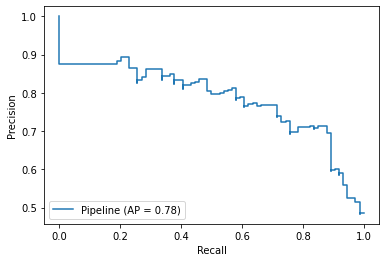

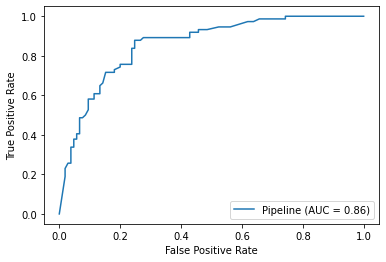

In [105]:
evaluate_clf(forest)

In [70]:
param_grid = {'forest__max_depth':[3,10,30,100],
              'forest__n_estimators':[10,30,100,300]}
tune_clf(forest,param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model params: {'forest__max_depth': 10, 'forest__n_estimators': 30}
Best model score: 0.806


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   15.7s finished


Experiment with plotting out feature importances

In [117]:
# importances = permutation_importance(forest,X_train,y_train)
# importances
# idx = [i for i,_ in enumerate(num_features + cat_features)]

# importances.importances_mean
# [i for i,__ in num_features.append(cat_features)]
# plt.barh(y = idx, width = importances.importances_mean)
# plt.xticks(num_features.append(cat_features))
# #forest['preprocessor']
# cat_names = forest['preprocessor'].named_transformers_['cats'].get_feature_names()
# #num_names = forest['preprocessor'].named_transformers_['nums'].steps[0]
# num_names = num_features
# feat_names = np.append(cat_names,num_features)
# print(len(feat_names))
 
# #prepocess
# feat_imp = forest['forest'].feature_importances_
 
# len(cat_names)
# feat_names
# #feat_imp
# feat_imp = feat_imp.reshape(1,-1)
# df_feat_imp = pd.DataFrame(feat_imp,columns=feat_names)
# df_feat_imp.plot(kind='barh')
# plt.yticks(df_feat_imp.columns)

array([0.09719101, 0.09747191, 0.1755618 , 0.18455056, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

# More features

## Logreg2 with all features

In [62]:
# Select the Features to model and 
X_all = df[['Title','Deck','Fare','Sex','Age','Embarked','familysize','Pclass','Ticket_Frequency','SibSp','Parch']]
y_all = df['Survived']
 
y = y_all[:rows_to_split]
X = X_all[:rows_to_split]
y_subm = y_all[rows_to_split:]
X_subm = X_all[rows_to_split:]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Define a model pipeline
num_features = ['Fare','Age','familysize','Ticket_Frequency','SibSp','Parch']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex','Embarked','Pclass']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
logreg2 = Pipeline([('preprocessor', preprocessor),
                       ('logreg', LogisticRegression(max_iter=1000))])

Accuracy on test set:  0.827
Precision score:       0.787
Recall score:          0.797
F1 score:              0.792
ROC AUC score:         0.822

CV scores: [0.82681564 0.82022472 0.79775281 0.8258427  0.85393258]
mean:      0.825
stdev:.    0.018


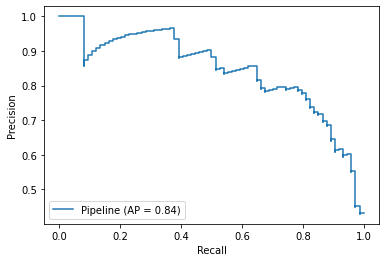

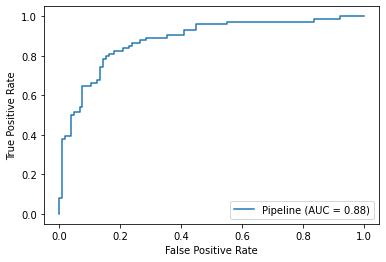

In [64]:
evaluate_clf(logreg2)

In [139]:
param_grid = {'logreg__C':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30]}
logreg2_tune = tune_clf(logreg2,param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model params: {'logreg__C': 10}
Best model score: 0.831


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.7s finished


## Random Forest with all features

In [118]:
# Define a model pipeline
num_features = ['Fare','Age','familysize','Ticket_Frequency','SibSp','Parch']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex','Embarked','Pclass']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
forest2 = Pipeline([('preprocessor', preprocessor),
                    ('forest', RandomForestClassifier())])

Accuracy on test set:  0.816
Precision score:       0.773
Recall score:          0.784
F1 score:              0.779
ROC AUC score:         0.811

CV scores: [0.81564246 0.79213483 0.83146067 0.76404494 0.83146067]
mean:      0.807
stdev:.    0.026


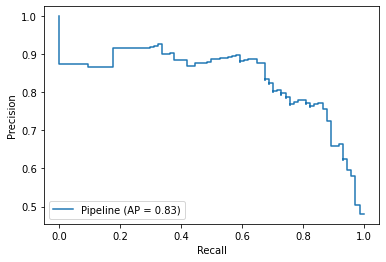

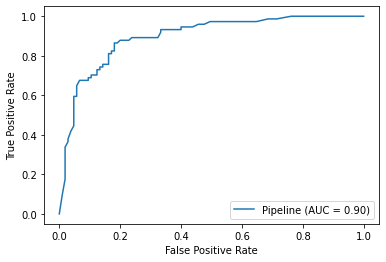

In [120]:
evaluate_clf(forest2)

In [124]:
param_grid = {'forest__max_depth':[3,10,30,100],
              'forest__n_estimators':[10,30,100,300]}
grid = tune_clf(forest,param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model params: {'forest__max_depth': 10, 'forest__n_estimators': 100}
Best model score: 0.805


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   16.0s finished


Accuracy on test set:  0.788
Precision score:       0.743
Recall score:          0.743
F1 score:              0.743
ROC AUC score:         0.781

CV scores: [0.76536313 0.78089888 0.83146067 0.75842697 0.81460674]
mean:      0.790
stdev:.    0.028


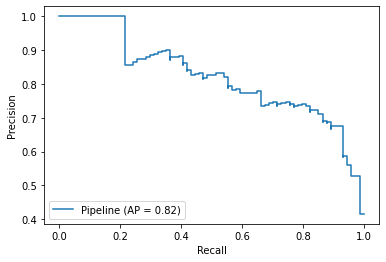

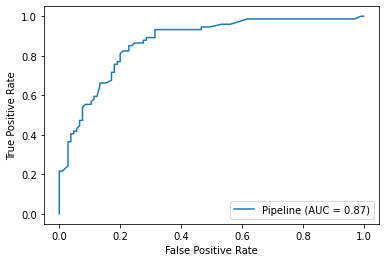

In [127]:
evaluate_clf(grid.best_estimator_)

# Tabulate metrics

# Construct output submission file

In [140]:
def generate_submission_df(clf):
  # input a fitted classifier
  df_test = pd.read_csv(os.path.join(path,'test.csv'))

  y_pred = clf.predict(X_subm)

  subm_dict = {'PassengerID':df_test.PassengerId,
               'Survived':y_pred.astype(int)}

  df_submission = pd.DataFrame(subm_dict)


  return df_submission

df_submission = generate_submission_df(logreg2_tune.best_estimator_)


df_submission.to_csv('titanic_submission.csv',index=False)